#Assignment 4

CNN

Name- Vipin Gupta

Roll no- 2011MT22

Importing libraries

In [ ]:
import gzip
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical

Load Data

In [ ]:
train_imgs = gzip.open('train-images-idx3-ubyte.gz','r') 
train_label = gzip.open('train-labels-idx1-ubyte.gz','r') 

test_imgs = gzip.open('t10k-images-idx3-ubyte.gz' ,'r') 
test_label = gzip.open('t10k-labels-idx1-ubyte.gz' ,'r') 

In [ ]:
image_size = 28
train_images = 60000
test_images = 10000

train_imgs.read(16)
buf_train = train_imgs.read(image_size * image_size * train_images)
X_train = np.frombuffer(buf_train, dtype=np.uint8).astype(np.float32)
X_train = X_train.reshape( train_images, image_size, image_size, 1)

test_imgs.read(16)
buf_test = test_imgs.read(image_size * image_size * test_images)
X_test = np.frombuffer(buf_test, dtype=np.uint8).astype(np.float32)
X_test = X_test.reshape( test_images, image_size, image_size, 1)

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
train_label.read(8)
y_train1 = []
for i in range(0,60000):   
    buf_train_label = train_label.read(1)
    labels = np.frombuffer(buf_train_label, dtype=np.uint8).astype(np.int64)
    y_train1.append(labels)
    
test_label.read(8)
y_test1 = []
for i in range(0,10000):   
    buf_test_label = test_label.read(1)
    labels = np.frombuffer(buf_test_label, dtype=np.uint8).astype(np.int64)
    y_test1.append(labels)
    
y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)

In [ ]:
y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

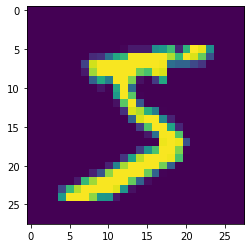

In [ ]:
import matplotlib.pyplot as plt
image = np.asarray(X_train[0]).squeeze()
plt.imshow(image)
plt.show()

#CNN Model with gridsearch for hyperparameter tuning

In [ ]:
def define_model(neurons=64,conv_filter=32,learn_rate=0.01,optimizer='Adam'):
  model = Sequential()
  model.add(Conv2D(conv_filter,(3, 3),activation='relu',kernel_initializer='he_uniform',input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
 
  model.add(Flatten()) 
  model.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  loss_fn='categorical_crossentropy'
  if optimizer=='Adam':
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
  else:
    opt = SGD(lr=learn_rate)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
  return model


In [ ]:
# create model
model = KerasClassifier(build_fn=define_model, verbose=0)



In [ ]:
# define the grid search parameters
batch_size = [64, 112]
epochs = [30, 40]
optimizer = ['SGD', 'Adam'] 
learn_rate = [0.001, 0.01]
neurons= [64,128]
conv_filter = [32,64]

param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate,neurons=neurons,optimizer=optimizer,conv_filter=conv_filter)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train, validation_split=0.1, verbose=1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/30
844/844 [==============================] - 6s 5ms/step - loss: 0.3387 - accuracy: 0.9047 - val_loss: 0.0746 - val_accuracy: 0.9787
Epoch 2/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0608 - accuracy: 0.9829 - val_loss: 0.0591 - val_accuracy: 0.9838
Epoch 3/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0383 - accuracy: 0.9892 - val_loss: 0.0481 - val_accuracy: 0.9862
Epoch 4/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0233 - accuracy: 0.9942 - val_loss: 0.0524 - val_accuracy: 0.9867
Epoch 5/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0182 - accuracy: 0.9959 - val_loss: 0.0461 - val_accuracy: 0.9867
Epoch 6/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.0462 - val_accuracy: 0.9870
Epoch 7/30
844/844 [==============================] - 4s 4ms/step - loss: 0.0093 - accuracy: 0.9989 - val_loss: 0.0456 - val_accuracy: 0.9875
Epoch 

#CNN Model with Data Augmentation at best parameter from gridsearch

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns

In [ ]:
# optimize parameters of the fit method 
cnn_model = define_model(neurons = grid_result.best_params_['neurons'],
                          learn_rate = grid_result.best_params_['learn_rate'],
                          optimizer = grid_result.best_params_['optimizer'],
                          conv_filter = grid_result.best_params_['conv_filter'])



In [ ]:
# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.1) 

datagen.fit(X_train)

history = cnn_model.fit_generator(datagen.flow(X_train,y_train, batch_size=grid_result.best_params_['batch_size'], subset='training'),
                                  epochs = grid_result.best_params_['epochs'], 
                                  validation_data =datagen.flow(X_train, y_train, batch_size=grid_result.best_params_['batch_size'], subset='validation'),
                                  verbose = 1)                        


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
844/844 [==============================] - 15s 18ms/step - loss: 1.4633 - accuracy: 0.5072 - val_loss: 0.7554 - val_accuracy: 0.7508
Epoch 2/30
844/844 [==============================] - 15s 17ms/step - loss: 0.7063 - accuracy: 0.7674 - val_loss: 0.5687 - val_accuracy: 0.8202
Epoch 3/30
844/844 [==============================] - 15s 17ms/step - loss: 0.5615 - accuracy: 0.8167 - val_loss: 0.4929 - val_accuracy: 0.8412
Epoch 4/30
844/844 [==============================] - 15s 17ms/step - loss: 0.4983 - accuracy: 0.8369 - val_loss: 0.4316 - val_accuracy: 0.8635
Epoch 5/30
844/844 [==============================] - 15s 17ms/step - loss: 0.4371 - accuracy: 0.8594 - val_loss: 0.4018 - val_accuracy: 0.8720
Epoch 6/30
844/844 [==============================] - 14s 17ms/step - loss: 0.4104 - accuracy: 0.8684 - val_loss: 0.3975 - val_accuracy: 0.8778
Epoch 7/30
844/844 [==============================] - 15s 17ms/step - loss: 0.3924 - accuracy: 0.8758 - val_loss: 0.3750 - val_accuracy:

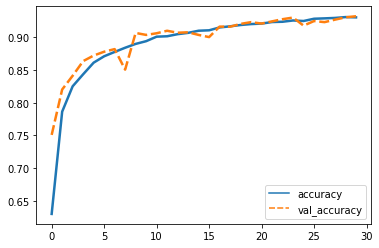

In [ ]:
# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);


#Classification Report (Accuracy, precision, F score, recall) and confusion matrix

In [ ]:
# predict classes for test set
yhat = cnn_model.predict(X_test) 

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

In [ ]:
ypred = np.argmax(yhat,axis=1)
ytest = np.argmax(y_test,axis=1)

In [ ]:
#Classification Report

print('Classification report')
print(metrics.classification_report(ytest,n,digits=3))


Classification report
              precision    recall  f1-score   support

           0      0.980     0.971     0.976       980
           1      0.997     0.872     0.930      1135
           2      0.974     0.943     0.958      1032
           3      0.959     0.981     0.970      1010
           4      0.878     0.997     0.934       982
           5      0.948     0.960     0.954       892
           6      0.939     0.979     0.959       958
           7      0.973     0.961     0.967      1028
           8      0.975     0.983     0.979       974
           9      0.968     0.949     0.958      1009

    accuracy                          0.958     10000
   macro avg      0.959     0.960     0.958     10000
weighted avg      0.960     0.958     0.958     10000



In [ ]:
conf_matrix = confusion_matrix(ytest, ypred)
print('Confusion Matrix: \n')
print(conf_matrix)

Confusion Matrix: 

[[ 946    0    2    5    0   19    3    0    3    2]
 [   0 1105    2   13    3    2    3    6    1    0]
 [   1    1  732   91    7  156   11   24    9    0]
 [   0    0    0  967    0   41    0    2    0    0]
 [   0    0    1    6  947    1    1    4    8   14]
 [   0    0    7   33    0  846    1    3    1    1]
 [   4    0   13   20    4   76  839    1    1    0]
 [   0    1   19   27    6   28    0  941    1    5]
 [   0    0   16   28    5   36    0    1  882    6]
 [   2    0    3   21    9   13    0   11   10  940]]
